# Classes 4 - Data classes round 2

In [1]:
# Import statements
import pandas as pd
import os
import datetime as dt
from datetime import timedelta
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import AutoLocator
import itertools
from itertools import product
import numpy as np
import csv
import operator

# Directories for reading and writing data
thedir = os.getcwd()
writedir = os.path.abspath(os.path.join(os.path.dirname(thedir), '..', 'data/interim'))
extdir = os.path.abspath(os.path.join(os.path.dirname(thedir), '..', 'data/external'))
figdir = os.path.abspath(os.path.join(os.path.dirname(thedir), '..', 'figures'))

# load data (reference data set of lcd and aws stations from 2018)
data_test = pd.read_csv(F'{extdir}/ref_2018.csv')
data_ = data_test[['Date_time_CET','BOLL_LCD_TEMP',
       'BOLL_AWS_TEMP', 'BOLL_PRECIP', 'BOLL_RADIATION_GLOBAL',
       'BOLL_WIND_SPEED_mean', 'ZOLL_STEVENSON_LCD_TEMP', 'ZOLL_2m_LCD_TEMP',
       'ZOLL_3m_LCD_TEMP', 'ZOLL_AWS_TEMP', 'ZOLL_RADIATION_GLOBAL',
       'ZOLL_SUNSHINE', 'ZOLL_PRECIP', 'ZOLL_WIND_SPEED_MEAN', 'AFU_LCD_TEMP',
       'AFU_AWS_TEMP', 'AFU_WIND_SPEED_MEAN', 'AFU_RADIATION_GLOBAL']]
data_.set_index('Date_time_CET',inplace=True)

In [2]:
class Thing:
    def __init__(self, value, index, header):
        self.name = header
        self.time = dt.datetime.strptime(index,'%d.%m.%Y %H:%M')
        self.value = value
        self.station = header[:3].lower()
        if 'LCD' in header:
            self.stype = 'lcd'
        else:
            self.stype = 'aws'
        if 'TEMP' in header:
            self.qty = 'temp'
        elif 'SUN':
            self.qty = 'sun'
        elif 'RADI':
            self.qty = 'rad'
        elif 'WIND':
            self.qty = 'wind'
        elif 'PREC':
            self.qty = 'prec'
    
    def get_period(self, strfkey):
        return dt.datetime.strftime(self.time,strfkey)
    
    def update_value(self,value):
        self.value = value

## Dictionary
Following code defines the variables stored with each data point (except for the values and the time samps!)

In [3]:
names = ['BOLL_LCD_TEMP','BOLL_AWS_TEMP', 'BOLL_PRECIP', 'BOLL_RADIATION_GLOBAL','BOLL_WIND_SPEED_mean', 'ZOLL_STEVENSON_LCD_TEMP',
         'ZOLL_2m_LCD_TEMP','ZOLL_3m_LCD_TEMP', 'ZOLL_AWS_TEMP', 'ZOLL_RADIATION_GLOBAL','ZOLL_SUNSHINE', 'ZOLL_PRECIP', 'ZOLL_WIND_SPEED_MEAN',
         'AFU_LCD_TEMP', 'AFU_AWS_TEMP', 'AFU_WIND_SPEED_MEAN', 'AFU_RADIATION_GLOBAL']
period_keys = {'hour':'%H','month':'%m','year':'%Y','day':'%j'}
qty = ['temp','wind','rad','sun','prec']
station = ['bol','zol','afu']
key = period_keys['day']

## Create list of objects

In [4]:
cols = data_.columns
mylist = []
for index,rows in data_.iterrows():
        mylist.append([Thing(data_.at[index,index_c],index,index_c) for index_c in cols])
ad = [x for y in mylist for x in y]
ad = sorted(ad, key=operator.attrgetter('time'))
times = list(set([x.time for x in ad]))
times = sorted(times)

## Fix incorrect data 
Bad data is keyed as -9999, following code replaces the bad valeus with the mean from the previous and next hour (excluding any potential bad values that also occur in that hour).

In [5]:
wrong = [x for x in ad if x.value < -50]
for i in wrong:
    lower = [x.value for x in ad if (x.name == i.name) & (i.time - timedelta(hours=1) < x.time < i.time) & (x.value > -100)]
    higher = [x.value for x in ad if (x.name == i.name) & (i.time < x.time < i.time + timedelta(hours=1)) & (x.value > -100)]
    new_val = (sum(lower) + sum(higher))/(len(lower) + len(higher))
    i.update_value(new_val)

In [6]:
a = [x.value for x in ad if x.name == 'BOLL_AWS_TEMP']
len(a)

17712

# AWS - LCD differences
Gets difference and cum difference for each data instance

In [7]:
boll_a = [x.value for x in ad if x.name == 'BOLL_AWS_TEMP']
boll_l = [x.value for x in ad if x.name == 'BOLL_LCD_TEMP']
val_b = [x - y for x, y in zip(boll_a, boll_l)]
val_bc = np.cumsum(val_b)
diff_b = list(zip(times,val_b,val_bc))

In [8]:
afu_a = [x.value for x in ad if x.name == 'AFU_AWS_TEMP']
afu_l = [x.value for x in ad if x.name == 'AFU_LCD_TEMP']
val_a = [x - y for x, y in zip(afu_a, afu_l)]
val_ac = np.cumsum(val_a)
diff_a = list(zip(times,val_a,val_ac))

In [9]:
print(len(diff_a))

17712


In [10]:
zoll_a = [x.value for x in ad if x.name == 'ZOLL_AWS_TEMP']
zoll_l2 = [x.value for x in ad if x.name == 'ZOLL_2m_LCD_TEMP']
zoll_l3 = [x.value for x in ad if x.name == 'ZOLL_3m_LCD_TEMP']
zoll_ls = [x.value for x in ad if x.name == 'ZOLL_STEVENSON_LCD_TEMP']
val_z2 = [x - y for x, y in zip(zoll_a, zoll_l2)]
val_z2c = np.cumsum(val_z2)
val_z3 = [x - y for x, y in zip(zoll_a, zoll_l3)]
val_z3c = np.cumsum(val_z3)
val_zs = [x - y for x, y in zip(zoll_a, zoll_ls)]
val_zsc = np.cumsum(val_zs)
diff_z2 = list(zip(times,val_z2,val_z2c))
diff_z3 = list(zip(times,val_z3,val_z3c))
diff_zs = list(zip(times,val_zs,val_zsc))

In [11]:
a = val_z2

In [12]:
types = set([x for x in a])

In [13]:
min(types)

-3.3000000000000007

In [26]:
type(val_z2)

list

In [29]:
val_z2[17000]

-0.3000000000000007

In [24]:
start = 0
mylist = []
for i in val_z2:
    start = start + i
    mylist.append(start)

In [25]:
start

nan

In [17]:
result = list(itertools.accumulate(a))

In [18]:
b = list(np.cumsum(a))

In [19]:
result[-10:]

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]

In [20]:
df = pd.DataFrame()
df['dcs_afu'] = val_ac
df['dcs_bol'] = val_bc
df['dcs_zol_2m'] = val_z2c
df['dcs_zol_3m'] = val_z3c
df['dcs_zol_steve'] = val_zsc
df['md'] = times

In [21]:
df

,dcs_afu,dcs_bol,dcs_zol_2m,dcs_zol_3m,dcs_zol_steve,md
0,0.4,0.6,0.1,0.1,0.1,2018-05-16 00:00:00
1,0.8,1.0,0.2,0.2,0.2,2018-05-16 00:10:00
2,1.0,1.9,0.3,0.3,0.3,2018-05-16 00:20:00
3,1.6,2.6,0.4,0.4,0.4,2018-05-16 00:30:00
4,2.1,2.9,0.5,0.5,0.5,2018-05-16 00:40:00
...,...,...,...,...,...,...
17707,NaN,NaN,NaN,NaN,NaN,2018-09-15 23:10:00
17708,NaN,NaN,NaN,NaN,NaN,2018-09-15 23:20:00
17709,NaN,NaN,NaN,NaN,NaN,2018-09-15 23:30:00
17710,NaN,NaN,NaN,NaN,NaN,2018-09-15 23:40:00


In [22]:
af_ = df.melt('md',value_name = 'cum-diff',var_name = 'station')

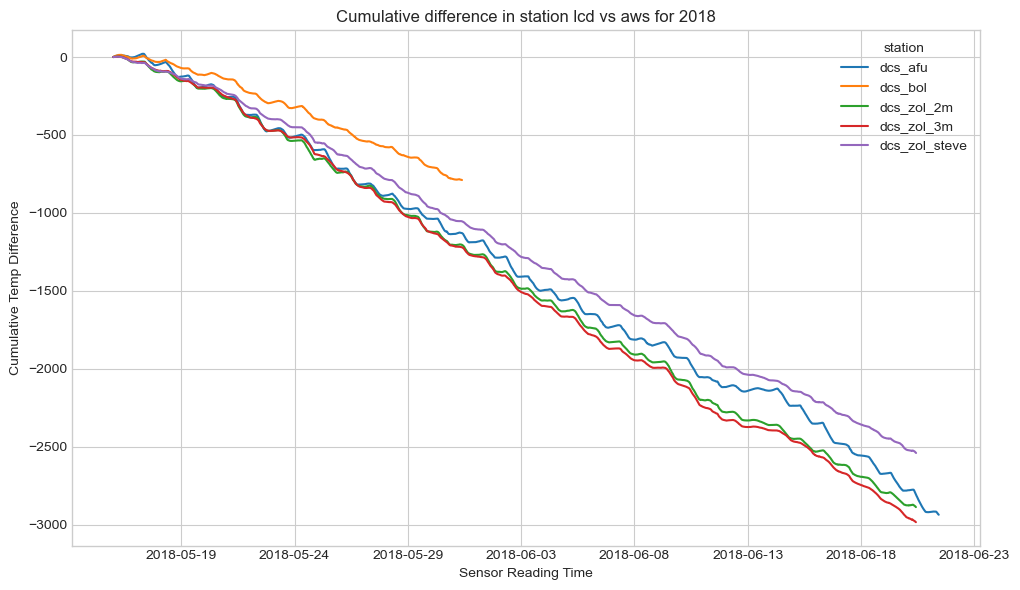

In [23]:
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('seaborn-whitegrid')

fig,axs = plt.subplots(figsize= (10,6))
sns.lineplot(data = af_, x = af_.md,y='cum-diff', hue = 'station')
plt.xlabel("Sensor Reading Time")
plt.ylabel("Cumulative Temp Difference")
plt.title("Cumulative difference in station lcd vs aws for 2018")
plt.tight_layout()
loc = AutoLocator()
axs.xaxis.set_major_locator(loc)
plt.savefig(F'{figdir}/cum-temp-diffs-new-classes.png')
plt.show()